In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
import json
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.utils import mask_to_categorical
from stardist.plot import render_label

import matplotlib.colors as mcolors
import copy

np.random.seed(0)
lbl_cmap = random_label_cmap()
lbl_cmap_classes = matplotlib.cm.tab20


def cus_plot_img_label(X_main, lbl, cls_dict):
    X_modified = X_main.copy()  # Create a copy of the input image

    c = mask_to_categorical(lbl, n_classes=4, classes=cls_dict)
    res = np.argmax(c, axis=-1).astype(np.uint16)

    colors = {
        1: (59 / 255, 154 / 255, 251 / 255),   # Blue for mask value 1
        2: (0 / 255, 255 / 255, 61 / 255),     # Green for mask value 2
        3: (250 / 255, 220 / 255, 57 / 255),   # Yellow for mask value 3
        4: (255 / 255, 0 / 255, 23 / 255)      # Red for mask value 4
    }

    h, w = res.shape[:2]
    mask_values = np.unique(res)

    for mask_value in mask_values:
        if mask_value in colors:
            color = colors[mask_value]
            mask = res == mask_value
            X_modified[mask] = color

    return X_modified


def plot_all(img, lbl, cls_dict, img_title="ROI", lbl_title="Ground truth", cls_title="Ground truth by Classs", font_size=18, **kwargs):
    
    plot_img=cus_plot_img_label(img,lbl,cls_dict)
    
    
    fig, (ai,al,ac) = plt.subplots(1,3, figsize=(17,7), gridspec_kw=dict(width_ratios=(1.,1,1)))
    im = ai.imshow(img, cmap='gray')
    #fig.colorbar(im, ax = ai)
    ai.set_title(img_title, fontsize=font_size)    
    al.imshow(render_label(lbl, .8*normalize(img, clip=True), normalize_img=False, alpha_boundary=.8,cmap=lbl_cmap))
    al.set_title(lbl_title, fontsize=font_size)
    ac.imshow(plot_img)
    ac.set_title(cls_title, fontsize=font_size)
    plt.tight_layout()    
    for a in ai,al,ac:
        a.axis("off")
    return ai,al,ac

In [2]:
# set the number of object classes
n_classes = 4

In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from tqdm import tqdm

def make_image(folder_paths, height, width):
    
    new_image = np.zeros((height, width), dtype=np.uint8)
    
    my_dict = {}

    class_name_reco = {
        'Blue': 1,
        'Green': 2,
        'Yellow': 3,
        'Red': 4
    }
    for i, path in enumerate(folder_paths):
        
        class_name= path.split('\\')[-1].split('_')[-2]
        reference_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        reference_image = cv2.resize(reference_image, (width, height))
        new_image[reference_image > 0 ] = i+1
        my_dict[i+1] = class_name_reco[class_name]
        
        
    return new_image, my_dict


    
X_test=[]
Y_test=[]
C_test=[]
for path in tqdm(os.listdir(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing')):
    roi=io.imread(glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/image/*.png')[0])
    height, width, _ = roi.shape
    #height, width, _ = [256,256,3]
    roi = transform.resize(roi, (height, width))
    
    folder_paths= glob.glob(r'C:\Users\DELL\Desktop\Final Work StarDist\Testing/'+path+'/color_masks/*.png')
    one_image, my_dict=make_image(folder_paths, height, width)
    
    X_test.append(roi)
    Y_test.append(one_image)
    C_test.append(my_dict)

100%|██████████| 44/44 [00:09<00:00,  4.78it/s]


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Ground truth'}>,
 <Axes: title={'center': 'Ground truth by Classs'}>)

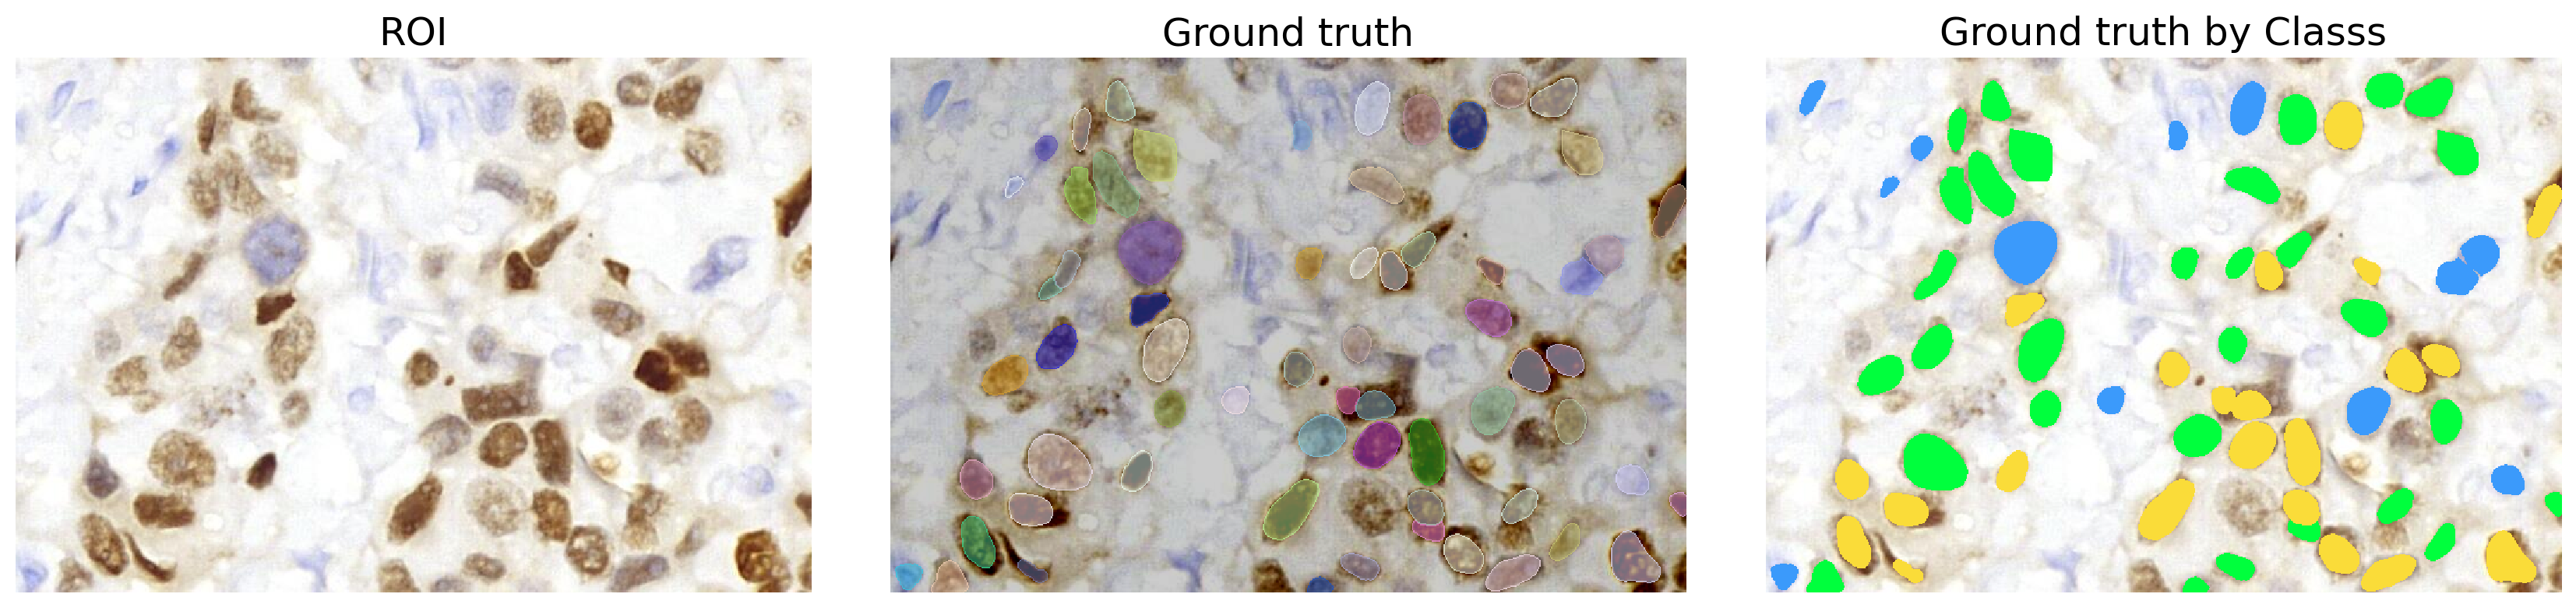

In [4]:
valuesss=24
plot_all(X_test[valuesss],Y_test[valuesss], C_test[valuesss])

In [5]:
model = StarDist2D(None, name='densenetsegnet_multiclass_ai4dp', basedir='models')

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   896         ['input[0][0]']                  
                                32)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   9248        ['conv2d[0][0]']                 
                                32)                                                     

                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, None, None,   512        ['conv2_block3_1_conv[0][0]']    
 ization)                       128)                                                              
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, None, None,   0          ['conv2_block3_1_bn[0][0]']      
 n)                             128)                                                              
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, None, None,   36864       ['conv2_block3_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv2_blo

                                128)                                                              
                                                                                                  
 pool2_pool (AveragePooling2D)  (None, None, None,   0           ['pool2_conv[0][0]']             
                                128)                                                              
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, None, None,   512        ['pool2_pool[0][0]']             
 ization)                       128)                                                              
                                                                                                  
 conv3_block1_0_relu (Activatio  (None, None, None,   0          ['conv3_block1_0_bn[0][0]']      
 n)                             128)                                                              
          

 conv3_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv3_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv3_block4_concat (Concatena  (None, None, None,   0          ['conv3_block3_concat[0][0]',    
 te)                            256)                              'conv3_block4_2_conv[0][0]']    
                                                                                                  
 conv3_block5_0_bn (BatchNormal  (None, None, None,   1024       ['conv3_block4_concat[0][0]']    
 ization)                       256)                                                              
                                                                                                  
 conv3_block5_0_relu (Activatio  (None, None, None,   0          ['conv3_block5_0_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block8_2_conv (Conv2D)   (None, None, None,   36864       ['conv3_block8_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv3_block8_concat (Concatena  (None, None, None,   0          ['conv3_block7_concat[0][0]',    
 te)                            384)                              'conv3_block8_2_conv[0][0]']    
                                                                                                  
 conv3_block9_0_bn (BatchNormal  (None, None, None,   1536       ['conv3_block8_concat[0][0]']    
 ization)                       384)                                                              
                                                                                                  
 conv3_blo

 on)                            128)                                                              
                                                                                                  
 conv3_block12_2_conv (Conv2D)  (None, None, None,   36864       ['conv3_block12_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv3_block12_concat (Concaten  (None, None, None,   0          ['conv3_block11_concat[0][0]',   
 ate)                           512)                              'conv3_block12_2_conv[0][0]']   
                                                                                                  
 pool3_bn (BatchNormalization)  (None, None, None,   2048        ['conv3_block12_concat[0][0]']   
                                512)                                                              
          

 conv4_block4_0_bn (BatchNormal  (None, None, None,   1408       ['conv4_block3_concat[0][0]']    
 ization)                       352)                                                              
                                                                                                  
 conv4_block4_0_relu (Activatio  (None, None, None,   0          ['conv4_block4_0_bn[0][0]']      
 n)                             352)                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, None, None,   45056       ['conv4_block4_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, None, None,   512        ['conv4_block4_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv4_block8_0_bn (BatchNormal  (None, None, None,   1920       ['conv4_block7_concat[0][0]']    
 ization)                       480)                                                              
                                                                                                  
 conv4_block8_0_relu (Activatio  (None, None, None,   0          ['conv4_block8_0_bn[0][0]']      
 n)                             480)                                                              
                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, None, None,   61440       ['conv4_block8_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv4_blo

 ate)                           608)                              'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, None, None,   2432       ['conv4_block11_concat[0][0]']   
 lization)                      608)                                                              
                                                                                                  
 conv4_block12_0_relu (Activati  (None, None, None,   0          ['conv4_block12_0_bn[0][0]']     
 on)                            608)                                                              
                                                                                                  
 conv4_block12_1_conv (Conv2D)  (None, None, None,   77824       ['conv4_block12_0_relu[0][0]']   
                                128)                                                              
          

 conv4_block15_concat (Concaten  (None, None, None,   0          ['conv4_block14_concat[0][0]',   
 ate)                           736)                              'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, None, None,   2944       ['conv4_block15_concat[0][0]']   
 lization)                      736)                                                              
                                                                                                  
 conv4_block16_0_relu (Activati  (None, None, None,   0          ['conv4_block16_0_bn[0][0]']     
 on)                            736)                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, None, None,   94208       ['conv4_block16_0_relu[0][0]']   
          

                                                                                                  
 conv4_block19_concat (Concaten  (None, None, None,   0          ['conv4_block18_concat[0][0]',   
 ate)                           864)                              'conv4_block19_2_conv[0][0]']   
                                                                                                  
 conv4_block20_0_bn (BatchNorma  (None, None, None,   3456       ['conv4_block19_concat[0][0]']   
 lization)                      864)                                                              
                                                                                                  
 conv4_block20_0_relu (Activati  (None, None, None,   0          ['conv4_block20_0_bn[0][0]']     
 on)                            864)                                                              
                                                                                                  
 conv4_blo

                                32)                                                               
                                                                                                  
 conv4_block23_concat (Concaten  (None, None, None,   0          ['conv4_block22_concat[0][0]',   
 ate)                           992)                              'conv4_block23_2_conv[0][0]']   
                                                                                                  
 conv4_block24_0_bn (BatchNorma  (None, None, None,   3968       ['conv4_block23_concat[0][0]']   
 lization)                      992)                                                              
                                                                                                  
 conv4_block24_0_relu (Activati  (None, None, None,   0          ['conv4_block24_0_bn[0][0]']     
 on)                            992)                                                              
          

 conv4_block27_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block27_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv4_block27_concat (Concaten  (None, None, None,   0          ['conv4_block26_concat[0][0]',   
 ate)                           1120)                             'conv4_block27_2_conv[0][0]']   
                                                                                                  
 conv4_block28_0_bn (BatchNorma  (None, None, None,   4480       ['conv4_block27_concat[0][0]']   
 lization)                      1120)                                                             
                                                                                                  
 conv4_block28_0_relu (Activati  (None, None, None,   0          ['conv4_block28_0_bn[0][0]']     
 on)      

                                                                                                  
 conv4_block31_2_conv (Conv2D)  (None, None, None,   36864       ['conv4_block31_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv4_block31_concat (Concaten  (None, None, None,   0          ['conv4_block30_concat[0][0]',   
 ate)                           1248)                             'conv4_block31_2_conv[0][0]']   
                                                                                                  
 conv4_block32_0_bn (BatchNorma  (None, None, None,   4992       ['conv4_block31_concat[0][0]']   
 lization)                      1248)                                                             
                                                                                                  
 conv4_blo

 ization)                       704)                                                              
                                                                                                  
 conv5_block3_0_relu (Activatio  (None, None, None,   0          ['conv5_block3_0_bn[0][0]']      
 n)                             704)                                                              
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, None, None,   90112       ['conv5_block3_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block3_1_conv[0][0]']    
 ization)                       128)                                                              
          

 conv5_block7_0_bn (BatchNormal  (None, None, None,   3328       ['conv5_block6_concat[0][0]']    
 ization)                       832)                                                              
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, None, None,   0          ['conv5_block7_0_bn[0][0]']      
 n)                             832)                                                              
                                                                                                  
 conv5_block7_1_conv (Conv2D)   (None, None, None,   106496      ['conv5_block7_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv5_block7_1_bn (BatchNormal  (None, None, None,   512        ['conv5_block7_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv5_block11_0_bn (BatchNorma  (None, None, None,   3840       ['conv5_block10_concat[0][0]']   
 lization)                      960)                                                              
                                                                                                  
 conv5_block11_0_relu (Activati  (None, None, None,   0          ['conv5_block11_0_bn[0][0]']     
 on)                            960)                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, None, None,   122880      ['conv5_block11_0_relu[0][0]']   
                                128)                                                              
                                                                                                  
 conv5_blo

 ate)                           1088)                             'conv5_block14_2_conv[0][0]']   
                                                                                                  
 conv5_block15_0_bn (BatchNorma  (None, None, None,   4352       ['conv5_block14_concat[0][0]']   
 lization)                      1088)                                                             
                                                                                                  
 conv5_block15_0_relu (Activati  (None, None, None,   0          ['conv5_block15_0_bn[0][0]']     
 on)                            1088)                                                             
                                                                                                  
 conv5_block15_1_conv (Conv2D)  (None, None, None,   139264      ['conv5_block15_0_relu[0][0]']   
                                128)                                                              
          

 conv5_block18_concat (Concaten  (None, None, None,   0          ['conv5_block17_concat[0][0]',   
 ate)                           1216)                             'conv5_block18_2_conv[0][0]']   
                                                                                                  
 conv5_block19_0_bn (BatchNorma  (None, None, None,   4864       ['conv5_block18_concat[0][0]']   
 lization)                      1216)                                                             
                                                                                                  
 conv5_block19_0_relu (Activati  (None, None, None,   0          ['conv5_block19_0_bn[0][0]']     
 on)                            1216)                                                             
                                                                                                  
 conv5_block19_1_conv (Conv2D)  (None, None, None,   155648      ['conv5_block19_0_relu[0][0]']   
          

                                                                                                  
 conv5_block22_concat (Concaten  (None, None, None,   0          ['conv5_block21_concat[0][0]',   
 ate)                           1344)                             'conv5_block22_2_conv[0][0]']   
                                                                                                  
 conv5_block23_0_bn (BatchNorma  (None, None, None,   5376       ['conv5_block22_concat[0][0]']   
 lization)                      1344)                                                             
                                                                                                  
 conv5_block23_0_relu (Activati  (None, None, None,   0          ['conv5_block23_0_bn[0][0]']     
 on)                            1344)                                                             
                                                                                                  
 conv5_blo

                                32)                                                               
                                                                                                  
 conv5_block26_concat (Concaten  (None, None, None,   0          ['conv5_block25_concat[0][0]',   
 ate)                           1472)                             'conv5_block26_2_conv[0][0]']   
                                                                                                  
 conv5_block27_0_bn (BatchNorma  (None, None, None,   5888       ['conv5_block26_concat[0][0]']   
 lization)                      1472)                                                             
                                                                                                  
 conv5_block27_0_relu (Activati  (None, None, None,   0          ['conv5_block27_0_bn[0][0]']     
 on)                            1472)                                                             
          

 conv5_block30_2_conv (Conv2D)  (None, None, None,   36864       ['conv5_block30_1_relu[0][0]']   
                                32)                                                               
                                                                                                  
 conv5_block30_concat (Concaten  (None, None, None,   0          ['conv5_block29_concat[0][0]',   
 ate)                           1600)                             'conv5_block30_2_conv[0][0]']   
                                                                                                  
 conv5_block31_0_bn (BatchNorma  (None, None, None,   6400       ['conv5_block30_concat[0][0]']   
 lization)                      1600)                                                             
                                                                                                  
 conv5_block31_0_relu (Activati  (None, None, None,   0          ['conv5_block31_0_bn[0][0]']     
 on)      

                                                                                                  
 zero_padding2d_1 (ZeroPadding2  (None, None, None,   0          ['conv1/relu[0][0]']             
 D)                             64)                                                               
                                                                                                  
 pool1 (MaxPooling2D)           (None, None, None,   0           ['zero_padding2d_1[0][0]']       
                                64)                                                               
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, None, None,   256        ['pool1[0][0]']                  
 ization)                       64)                                                               
                                                                                                  
 conv2_blo

 n)                             128)                                                              
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, None, None,   36864       ['conv2_block4_1_relu[0][0]']    
                                32)                                                               
                                                                                                  
 conv2_block4_concat (Concatena  (None, None, None,   0          ['conv2_block3_concat[0][0]',    
 te)                            192)                              'conv2_block4_2_conv[0][0]']    
                                                                                                  
 conv2_block5_0_bn (BatchNormal  (None, None, None,   768        ['conv2_block4_concat[0][0]']    
 ization)                       192)                                                              
          

 conv3_block2_0_bn (BatchNormal  (None, None, None,   640        ['conv3_block1_concat[0][0]']    
 ization)                       160)                                                              
                                                                                                  
 conv3_block2_0_relu (Activatio  (None, None, None,   0          ['conv3_block2_0_bn[0][0]']      
 n)                             160)                                                              
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, None, None,   20480       ['conv3_block2_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, None, None,   512        ['conv3_block2_1_conv[0][0]']    
 ization) 

                                                                                                  
 conv3_block6_0_bn (BatchNormal  (None, None, None,   1152       ['conv3_block5_concat[0][0]']    
 ization)                       288)                                                              
                                                                                                  
 conv3_block6_0_relu (Activatio  (None, None, None,   0          ['conv3_block6_0_bn[0][0]']      
 n)                             288)                                                              
                                                                                                  
 conv3_block6_1_conv (Conv2D)   (None, None, None,   36864       ['conv3_block6_0_relu[0][0]']    
                                128)                                                              
                                                                                                  
 conv3_blo

 te)                            416)                              'conv3_block9_2_conv[0][0]']    
                                                                                                  
 conv3_block10_0_bn (BatchNorma  (None, None, None,   1664       ['conv3_block9_concat[0][0]']    
 lization)                      416)                                                              
                                                                                                  
 conv3_block10_0_relu (Activati  (None, None, None,   0          ['conv3_block10_0_bn[0][0]']     
 on)                            416)                                                              
                                                                                                  
 conv3_block10_1_conv (Conv2D)  (None, None, None,   53248       ['conv3_block10_0_relu[0][0]']   
                                128)                                                              
          

 up_sampling2d (UpSampling2D)   (None, None, None,   0           ['batch_normalization[0][0]']    
                                512)                                                              
                                                                                                  
 conv2d_3 (Conv2D)              (None, None, None,   1179904     ['up_sampling2d[0][0]']          
                                256)                                                              
                                                                                                  
 batch_normalization_1 (BatchNo  (None, None, None,   1024       ['conv2d_3[0][0]']               
 rmalization)                   256)                                                              
                                                                                                  
 up_sampling2d_1 (UpSampling2D)  (None, None, None,   0          ['batch_normalization_1[0][0]']  
          

In [6]:
# model.optimize_thresholds(X_test, Y_test)

In [7]:
i = 42
label, res = model.predict_instances(X_test[i], n_tiles=model._guess_n_tiles(X_test[i]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 0s 32ms/step



  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step



 50%|█████     | 1/2 [00:01<00:01,  1.85s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


In [8]:
# the class object ids are stored in the 'results' dict and correspond to the label ids in increasing order 
def class_from_res(res):
    cls_dict = dict((i+1,c) for i,c in enumerate(res['class_id']))
    return cls_dict


(<Axes: title={'center': 'ROI'}>,
 <Axes: title={'center': 'Predict'}>,
 <Axes: title={'center': 'Predict by Classs'}>)

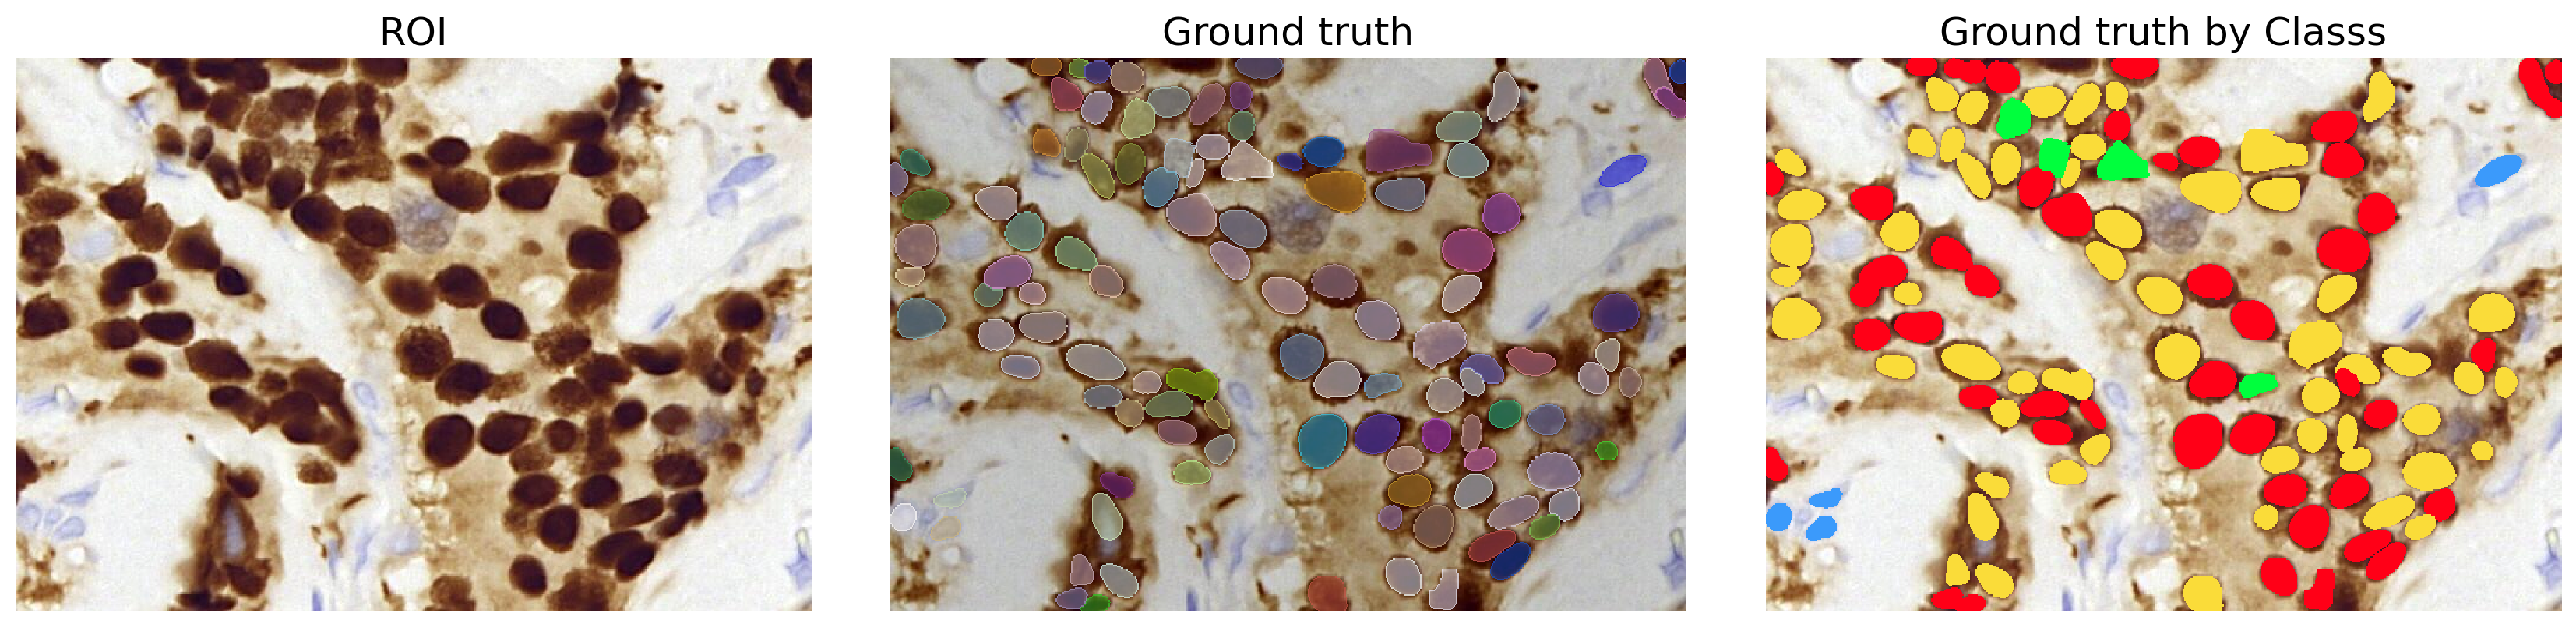

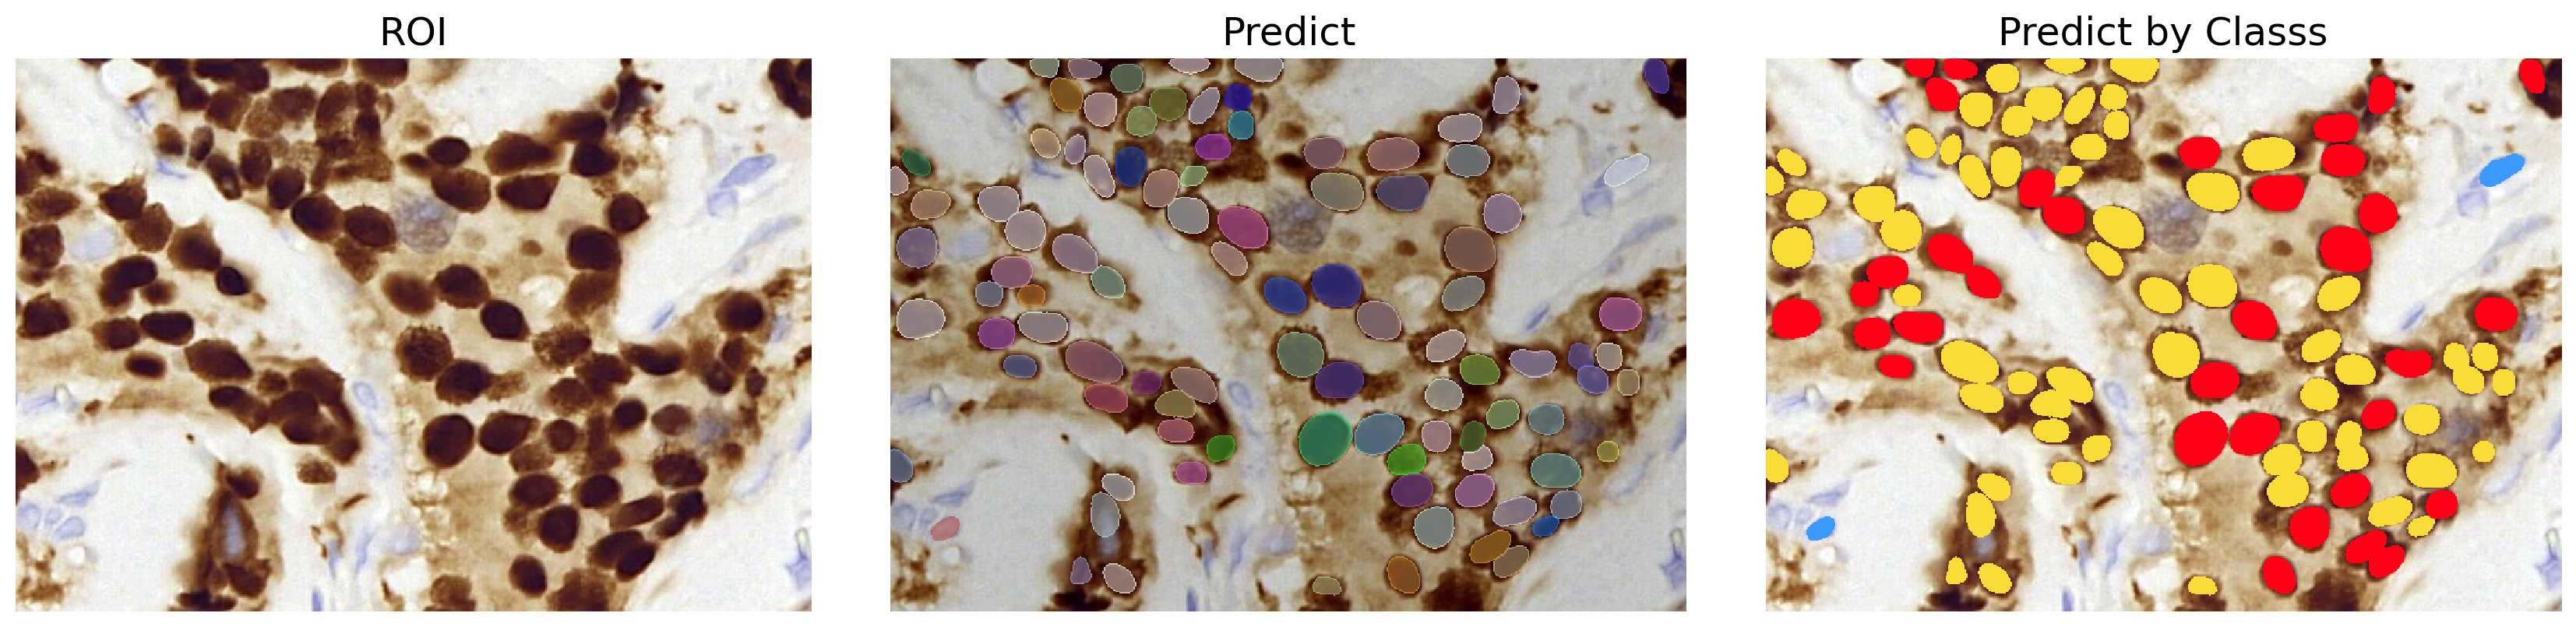

In [9]:
plot_all(X_test[i], Y_test[i], C_test[i],            lbl_title="Ground truth", cls_title="Ground truth by Classs")
plot_all(X_test[i], label,    class_from_res(res), lbl_title="Predict", cls_title="Predict by Classs")

In [10]:
Y_test_pred, res_test_pred = tuple(zip(*[model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)
              for x in tqdm(X_test[:])]))


  0%|          | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step



  2%|▏         | 1/44 [00:01<01:16,  1.78s/it]

1/1 [==============================] - 0s 30ms/step



  5%|▍         | 2/44 [00:02<00:53,  1.27s/it]

1/1 [==============================] - 0s 23ms/step



  7%|▋         | 3/44 [00:04<00:56,  1.38s/it]

1/1 [==============================] - 0s 22ms/step



  9%|▉         | 4/44 [00:04<00:37,  1.07it/s]

1/1 [==============================] - 0s 23ms/step



 11%|█▏        | 5/44 [00:04<00:27,  1.44it/s]

1/1 [==============================] - 0s 22ms/step



 14%|█▎        | 6/44 [00:04<00:20,  1.82it/s]

1/1 [==============================] - 0s 23ms/step



 16%|█▌        | 7/44 [00:05<00:16,  2.26it/s]

1/1 [==============================] - 0s 22ms/step



 18%|█▊        | 8/44 [00:06<00:27,  1.29it/s]

1/1 [==============================] - 0s 21ms/step



 20%|██        | 9/44 [00:08<00:35,  1.02s/it]

1/1 [==============================] - 0s 26ms/step



 23%|██▎       | 10/44 [00:09<00:33,  1.00it/s]

1/1 [==============================] - 0s 26ms/step



 25%|██▌       | 11/44 [00:09<00:25,  1.29it/s]

1/1 [==============================] - 0s 23ms/step



 27%|██▋       | 12/44 [00:09<00:19,  1.65it/s]

1/1 [==============================] - 0s 23ms/step



 30%|██▉       | 13/44 [00:11<00:27,  1.12it/s]

1/1 [==============================] - 0s 22ms/step



 32%|███▏      | 14/44 [00:11<00:21,  1.38it/s]

1/1 [==============================] - 0s 22ms/step



 34%|███▍      | 15/44 [00:12<00:22,  1.27it/s]

1/1 [==============================] - 0s 21ms/step



 36%|███▋      | 16/44 [00:12<00:18,  1.55it/s]

1/1 [==============================] - 0s 23ms/step



 39%|███▊      | 17/44 [00:13<00:15,  1.79it/s]

1/1 [==============================] - 0s 25ms/step



 41%|████      | 18/44 [00:13<00:13,  1.99it/s]

1/1 [==============================] - 0s 24ms/step



 43%|████▎     | 19/44 [00:13<00:10,  2.31it/s]

1/1 [==============================] - 0s 23ms/step



 45%|████▌     | 20/44 [00:14<00:14,  1.61it/s]

1/1 [==============================] - 0s 22ms/step



 48%|████▊     | 21/44 [00:16<00:20,  1.12it/s]

1/1 [==============================] - 0s 24ms/step



 50%|█████     | 22/44 [00:17<00:23,  1.06s/it]

1/1 [==============================] - 0s 23ms/step



 52%|█████▏    | 23/44 [00:18<00:18,  1.16it/s]

1/1 [==============================] - 0s 22ms/step



 55%|█████▍    | 24/44 [00:20<00:22,  1.14s/it]

1/1 [==============================] - 0s 22ms/step



 57%|█████▋    | 25/44 [00:20<00:16,  1.16it/s]

1/1 [==============================] - 0s 22ms/step



 59%|█████▉    | 26/44 [00:21<00:19,  1.08s/it]

1/1 [==============================] - 0s 22ms/step



 61%|██████▏   | 27/44 [00:22<00:18,  1.08s/it]

1/1 [==============================] - 0s 22ms/step



 64%|██████▎   | 28/44 [00:24<00:19,  1.20s/it]

1/1 [==============================] - 0s 23ms/step



 66%|██████▌   | 29/44 [00:25<00:17,  1.15s/it]

1/1 [==============================] - 0s 23ms/step



 68%|██████▊   | 30/44 [00:27<00:18,  1.33s/it]

1/1 [==============================] - 0s 22ms/step



 70%|███████   | 31/44 [00:27<00:13,  1.00s/it]

1/1 [==============================] - 0s 26ms/step



 73%|███████▎  | 32/44 [00:28<00:12,  1.03s/it]

1/1 [==============================] - 0s 23ms/step



 75%|███████▌  | 33/44 [00:28<00:08,  1.26it/s]

1/1 [==============================] - 0s 23ms/step



 77%|███████▋  | 34/44 [00:29<00:06,  1.53it/s]

1/1 [==============================] - 0s 22ms/step



 80%|███████▉  | 35/44 [00:29<00:05,  1.75it/s]

1/1 [==============================] - 0s 21ms/step



 82%|████████▏ | 36/44 [00:29<00:03,  2.11it/s]

1/1 [==============================] - 0s 26ms/step



 84%|████████▍ | 37/44 [00:31<00:05,  1.23it/s]

1/1 [==============================] - 0s 23ms/step



 86%|████████▋ | 38/44 [00:32<00:06,  1.01s/it]

1/1 [==============================] - 0s 23ms/step



 89%|████████▊ | 39/44 [00:33<00:05,  1.00s/it]

1/1 [==============================] - 0s 23ms/step



 91%|█████████ | 40/44 [00:34<00:03,  1.03it/s]

1/1 [==============================] - 0s 29ms/step



 93%|█████████▎| 41/44 [00:36<00:03,  1.17s/it]

1/1 [==============================] - 0s 23ms/step



 95%|█████████▌| 42/44 [00:37<00:02,  1.27s/it]

1/1 [==============================] - 0s 22ms/step



 98%|█████████▊| 43/44 [00:38<00:00,  1.04it/s]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 44/44 [00:39<00:00,  1.11it/s]


In [11]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_test, Y_test_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:04<00:00,  1.90it/s]


In [12]:
stats[taus.index(0.3)]

DatasetMatching(criterion='iou', thresh=0.3, fp=385, tp=3711, fn=554, precision=0.906005859375, recall=0.87010550996483, accuracy=0.7980645161290323, f1=0.8876928597057768, n_true=4265, n_pred=4096, mean_true_score=0.6918436490916423, mean_matched_score=0.7951261555849783, panoptic_quality=0.7058278108780898, by_image=False)

In [ ]:
for i in range(44):
    plot_all(X_test[i],Y_test[i],      C_test[i],                        lbl_title="Ground truth", cls_title="Ground truth by Classs")
    plot_all(X_test[i],Y_test_pred[i], class_from_res(res_test_pred[i]), lbl_title="Predict", cls_title="Predict by Classs");

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

all_f1=[]
all_recall=[]
all_pre=[]

for i in range(44):
    true_value = []
    predic_value = []
    for key, value in C_test[i].items():
        highlighted_image = np.zeros_like(Y_test[i])  # Create an image filled with zeros
        highlighted_image[Y_test[i] == key] = 1  # Set the pixels with the specific value to the value itself



        highlighted_image_2 = highlighted_image*Y_test_pred[i]
        flattened_matrix = highlighted_image_2.flatten()
        undesired_value = 0
        filtered_values = flattened_matrix[flattened_matrix != undesired_value]
        unique_values, counts = np.unique(filtered_values, return_counts=True)
        #highlighted_image_2[np.logical_and(highlighted_image, Y_test_pred[i]) == True] = value

        if len(counts) != 0:
            max_index = np.argmax(counts)

            true_value.append(value)
            predic_value.append(class_from_res(res_test_pred[i]).get(unique_values[max_index]))
            
    # Calculate precision, recall, and F1 score
    precision = precision_score(true_value, predic_value, average='macro')
    recall = recall_score(true_value, predic_value, average='macro')
    f1 = f1_score(true_value, predic_value, average='macro')
    
    all_f1.append(f1)
    all_pre.append(precision)
    all_recall.append(recall)

    print(f"Image: {i}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n\n")

_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 0
Precision: 0.5
Recall: 0.49444444444444446
F1 Score: 0.49720670391061456


Image: 1
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 2
Precision: 0.5
Recall: 0.49264705882352944
F1 Score: 0.4962962962962963


Image: 3
Precision: 1.0
Recall: 1.0
F1 Score: 1.0




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 4
Precision: 0.5
Recall: 0.49731182795698925
F1 Score: 0.49865229110512127


Image: 5
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 6
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 7
Precision: 0.7453259711324227
Recall: 0.7153996101364523
F1 Score: 0.7251888341543514


Image: 8
Precision: 0.5
Recall: 0.4921875
F1 Score: 0.49606299212598426




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 9
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 10
Precision: 0.5
Recall: 0.4966216216216216
F1 Score: 0.4983050847457627




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 11
Precision: 0.9222222222222223
Recall: 0.8653846153846154
F1 Score: 0.880053547523427


Image: 12
Precision: 0.6633986928104575
Recall: 0.6666666666666666
F1 Score: 0.6650246305418719


Image: 13
Precision: 0.5432900432900433
Recall: 0.5148148148148147
F1 Score: 0.5186274509803921




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 14
Precision: 0.5824670824670825
Recall: 0.5332776385407964
F1 Score: 0.5468369829683698


Image: 15
Precision: 0.5
Recall: 0.4857142857142857
F1 Score: 0.49275362318840576


Image: 16
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 17
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 18
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 19
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 20
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 21
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 22
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 23
Precision: 0.6714285714285715
Recall: 0.6320785070785071
F1 Score: 0.649447056774643


Image: 24
Precision: 0.6557471264367816
Recall: 0.6339285714285714
F1 Score: 0.6294871794871795




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 25
Precision: 0.5517665130568357
Recall: 0.5356410256410257
F1 Score: 0.5406559877955759


Image: 26
Precision: 0.8095238095238095
Recall: 0.8356164383561644
F1 Score: 0.7839922854387658




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 27
Precision: 0.38579945799457993
Recall: 0.39055555555555554
F1 Score: 0.38814814814814813


Image: 28
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 29
Precision: 0.936372269705603
Recall: 0.9484126984126983
F1 Score: 0.9418181818181818




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 30
Precision: 0.5743243243243243
Recall: 0.4954337899543379
F1 Score: 0.5265306122448979


Image: 31
Precision: 0.6728208232445521
Recall: 0.6736216874809625
F1 Score: 0.6697154471544715




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 32
Precision: 0.6506666666666666
Recall: 0.5886363636363636
F1 Score: 0.6153741496598639


Image: 33
Precision: 0.3218390804597701
Recall: 0.3218390804597701
F1 Score: 0.3218390804597701


Image: 34
Precision: 0.6358787878787878
Recall: 0.5798496240601503
F1 Score: 0.5799659799659799


Image: 35
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


Image: 36
Precision: 0.6334717134717135
Recall: 0.5790972468391823
F1 Score: 0.5866974022146436




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 37
Precision: 0.5
Recall: 0.4945054945054945
F1 Score: 0.4972375690607735




_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


Image: 38
Precision: 0.3304093567251462
Recall: 0.3333333333333333
F1 Score: 0.3318649045521292


Image: 39
Precision: 0.6556776556776557
Recall: 0.41292134831460675
F1 Score: 0.45925925925925926


Image: 40
Precision: 0.6702791461412151
Recall: 0.5655677655677656
F1 Score: 0.5822377622377621




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
_classification.py (1469): Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Image: 41
Precision: 0.6666666666666666
Recall: 0.6626506024096385
F1 Score: 0.6646464646464647


Image: 42
Precision: 0.6388888888888888
Recall: 0.6367864693446088
F1 Score: 0.635224976066376


Image: 43
Precision: 0.47697478991596637
Recall: 0.47212121212121205
F1 Score: 0.4667705627705628




_classification.py (1469): Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


In [16]:
import statistics

print(f"Precision: {statistics.mean(all_pre)}")
print(f"Recall: {statistics.mean(all_recall)}")
print(f"F1 Score: {statistics.mean(all_f1)}\n\n")

Precision: 0.7248918104574946
Recall: 0.7056151567864583
F1 Score: 0.708770941984001




In [17]:
# --------------------------Optimised for Speed
def get_fast_aji(true, pred):
    """AJI version distributed by MoNuSeg, has no permutation problem but suffered from 
    over-penalisation similar to DICE2.

    Fast computation requires instance IDs are in contiguous orderding i.e [1, 2, 3, 4] 
    not [2, 3, 6, 10]. Please call `remap_label` before hand and `by_size` flag has no 
    effect on the result.

    """
    true = np.copy(true)  # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [
        None,
    ]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)

    pred_masks = [
        None,
    ]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)

    # prefill with value
    pairwise_inter = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )
    pairwise_union = np.zeros(
        [len(true_id_list) - 1, len(pred_id_list) - 1], dtype=np.float64
    )

    # caching pairwise
    for true_id in true_id_list[1:]:  # 0-th is background
        t_mask = true_masks[true_id]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0:  # ignore
                continue  # overlaping background
            p_mask = pred_masks[pred_id]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[true_id - 1, pred_id - 1] = inter
            pairwise_union[true_id - 1, pred_id - 1] = total - inter

    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()

    paired_true = list(paired_true + 1)  # index to instance ID
    paired_pred = list(paired_pred + 1)
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array(
        [idx for idx in true_id_list[1:] if idx not in paired_true]
    )
    unpaired_pred = np.array(
        [idx for idx in pred_id_list[1:] if idx not in paired_pred]
    )
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()

    aji_score = overall_inter / overall_union
    return aji_score


all_aji_score=[]
for m in range(44):
    aji_score = get_fast_aji(Y_test[m],Y_test_pred[m])
    all_aji_score.append(aji_score)

print(all_aji_score)
print('Total AJI: ', (sum(all_aji_score) / len(all_aji_score)))

[0.6659098547369208, 0.6543828371662201, 0.7159024318781131, 0.6579149121875848, 0.6236451650989807, 0.6156174516908213, 0.8411684238622714, 0.62753914304338, 0.6345758382578955, 0.6366500872373115, 0.7440821154008617, 0.7603163741107946, 0.7353270306772139, 0.5103294249022893, 0.7498244954863206, 0.6992229637078343, 0.6530687002564188, 0.6968445554033, 0.6406098075547157, 0.7288101853053948, 0.8101860172537743, 0.7632578457101175, 0.7161448537284065, 0.6651717642837923, 0.6135423980029644, 0.5145422048907303, 0.7448263873799488, 0.6889153008882772, 0.6352363237468402, 0.6831103678929766, 0.7034911357194416, 0.6265092946490618, 0.5811388311388311, 0.577433934418669, 0.669877099215931, 0.7204443237755717, 0.5894810583607264, 0.6586695538032595, 0.6626162605126226, 0.6643585205472373, 0.6181433231792944, 0.696345058403706, 0.699977334271774, 0.6214891774891775]
Total AJI:  0.6708329583460857
